# **High-Confidence Thresholding**

**Authors:** Daniel Caron and William Specht
    
**In this notebook, we will walk through how to verify and adjust gene and ADT expression thresholds in order to create accurate high-confidence cell calls to use for classification.**

## **Import packages**

In [1]:
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mmochi as mmc
import os
plt.rcParams['figure.dpi'] = 150
mmc.log_to_file('thresholding')

Set the global defaults for data_key and batch_key, so that we don't need to pass them to every function

In [2]:
mmc.DATA_KEY = 'landmark_protein'
mmc.BATCH_KEY = 'batch'

## **Downloading and preprocessing the data**

<div class="alert alert-danger">
    
**Run Integrated Classification First!** 
    
This tutorial builds off of the [Integrated Classification tutorial](./Integrated_Classification.ipynb), and uses the MMoCHi hierarchy designed and saved during that tutorial.
</div>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Here, we will demonstrate thresholding using two 10X Genomics sequencing runs (pbmc_10k_protein_v3 and 5k_pbmc_protein_v3). This function downloads and preprocesses that data. We will also load in our unsupervised analysis for reference (see the [Integrated Classification tutorial](./Integrated_Classification.ipynb) for more details).

In [3]:
batches = ['pbmc_10k_protein_v3','5k_pbmc_protein_v3']
files = ['data/pbmc_10k_protein_v3.h5','data/5k_pbmc_protein_v3.h5']
urls = ['http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_protein_v3/pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5',
        'http://cf.10xgenomics.com/samples/cell-exp/3.0.2/5k_pbmc_protein_v3/5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5']
adatas = mmc.utils.preprocess_adatas(files, backup_urls=urls, log_CP_ADT=1e3, log_CP_GEX=1e4)
adata = anndata.concat(adatas, merge='first', keys=batches, label='batch', index_unique='_')
adata.obsm['protein'].drop(['IgG2a_control','IgG2b_control','IgG1_control'], axis=1, inplace=True)
adata = mmc.landmark_register_adts(adata, single_peaks=['CD25'])

assert os.path.isfile('data/Integrated_Classification_X_umap.txt') & os.path.isfile('data/Integrated_Classification_leiden.csv'), \
    'Objects not found. Run the Integrated Clasification tutorial to generate them!'
adata.obsm['X_umap'] = np.loadtxt('data/Integrated_Classification_X_umap.txt')
adata.obs['leiden'] = pd.read_csv('data/Integrated_Classification_leiden.csv', index_col=0).astype(str).astype('category')
adata.var = adata.var.astype('category')

Running with batch batch


  0%|          | 0/2 [00:00<?, ?it/s]

## **Load the hierarchy**

For convenience, we have loaded in a prebuilt hierarchy. High-confidence definitions for each cell type are displayed below each subset name:

Loading classifier from data/IntegratedClassifier...


Loaded data/IntegratedClassifier.hierarchy


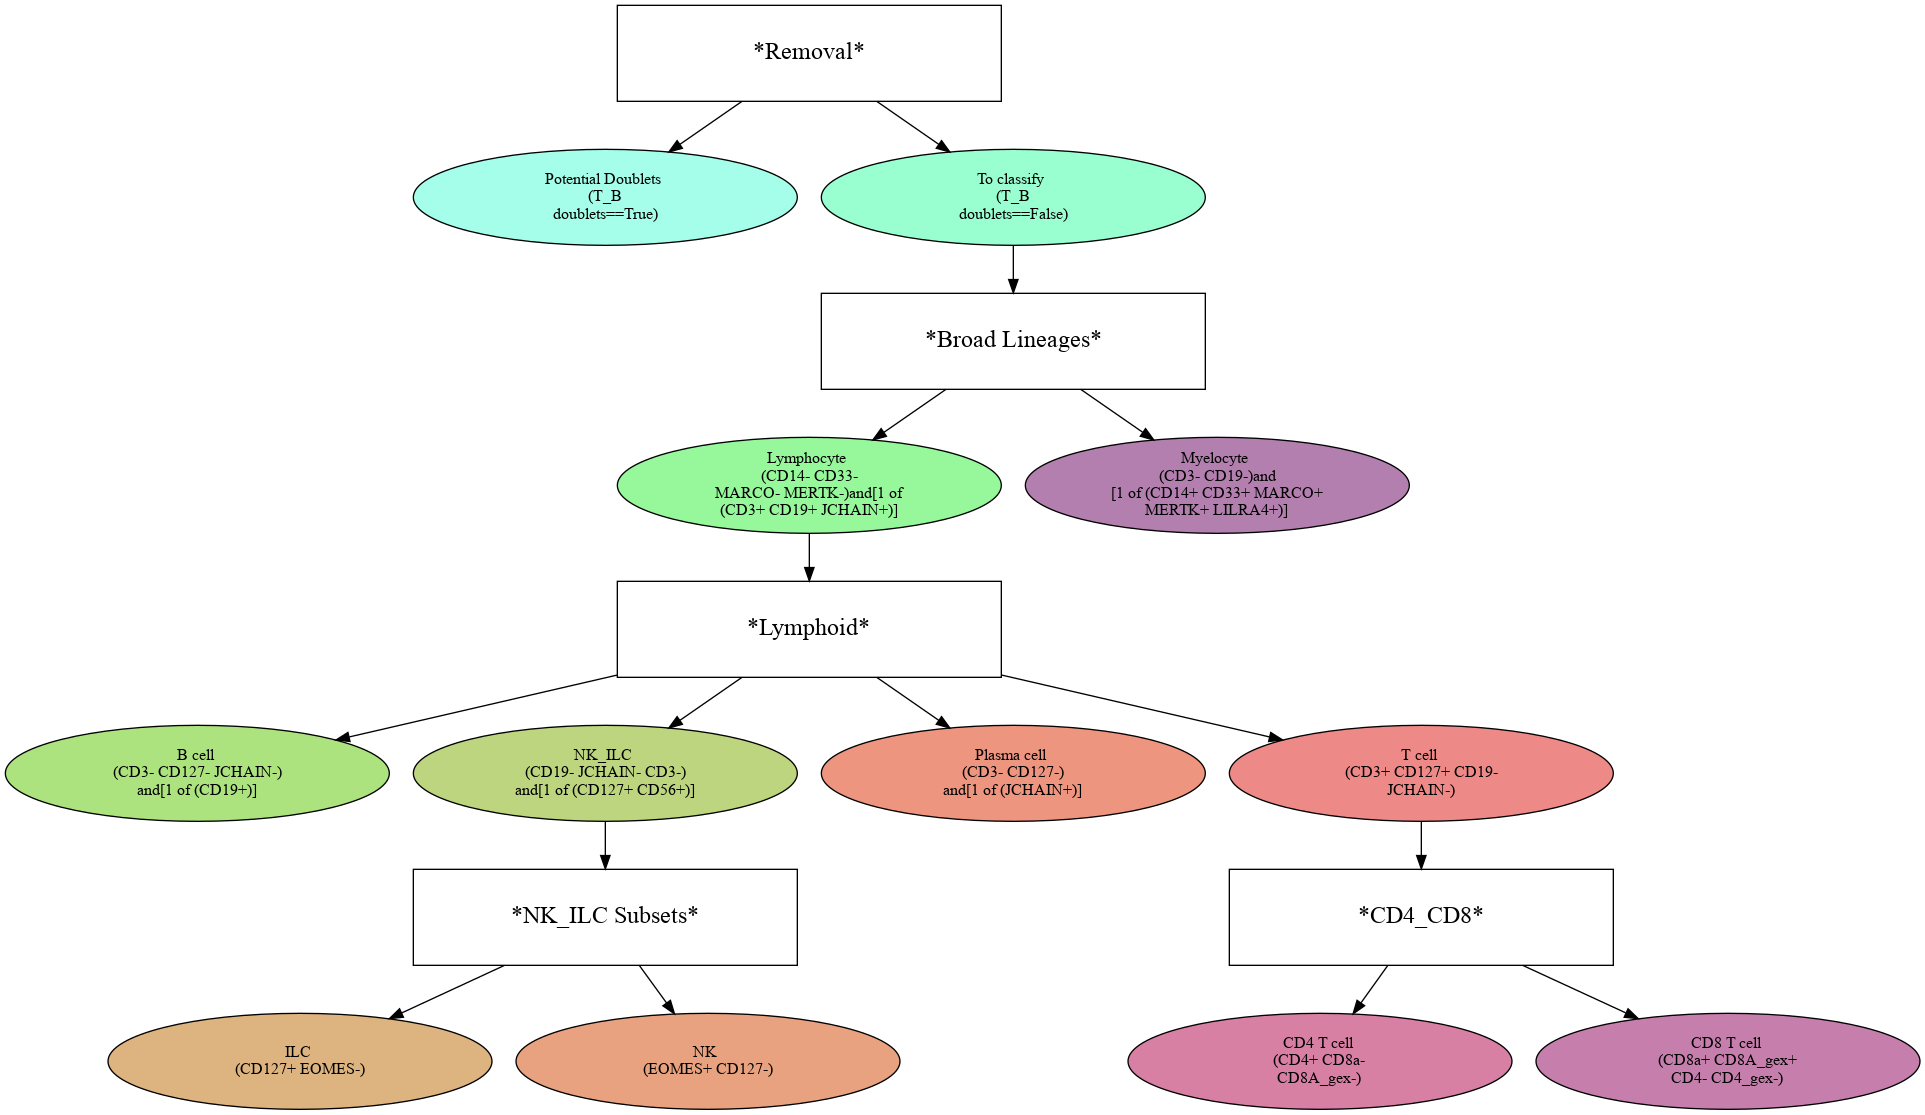

In [4]:
assert os.path.isfile('data/IntegratedClassifier.hierarchy'), 'Object not found. Run the Integrated Clasification tutorial to generate it!'

h = mmc.Hierarchy(load='data/IntegratedClassifier')
h.color_dict(True, rot=1, hue=3, mode='DEPTH')
h.display(True, font_mult=.75)

## **Threshold high-confidence markers**
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In order to select high-confidence events for training, we must first identify positive and negative populations for each marker used in hierarchical definition. These thresholds are then stored in the hierarchy object for classification and will also be saved out as a .csv for reference. Thresholding can be performed on any transformation of the ADTs that produces clear positive and negative populations. Although MMoCHi will attempt to predict thresholds from a Gaussian mixture model, these predictions are far from perfect. Thresholds must be carefully defined for each marker used in the hierarchy for each sample. Gaussian mixture models are only calculated for proteins, as most thresholds for gene expression markers are all-or-nothing (more on that later). As a general rule, thresholds should be drawn tightly enough that they are greater than 95% pure for events. This, when combined with multiple positive or negative marker definitions for each subset, should lead to highly pure high-confidence events for training.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Let's see how thresholding looks with no modification. Histograms are colored blue for negative gate, orange for the positive gate, and green for the ungated intermediate. As many of these markers have high rates of dropout, events with 0 expression of a marker have been hidden. The percent of the dataset with non-zero expression of a marker is displayed above each plot as an aid. The orange, black, and blue curve show the predicted Gaussian mixture model. The best fitting mixture model, including 1, 2, or 3 Gaussians, is chosen for each marker, and thresholds are automatically defined as 2-4 standard deviations away from the modes of the most positive and negative peaks. As you can see, the Gaussian model sometimes fails to detect peaks:

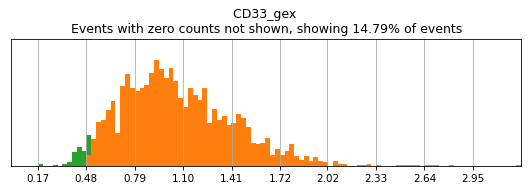

(0.5, 0)


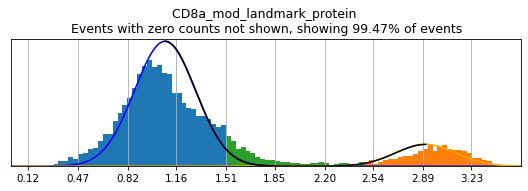

(2.4842246732501505, 1.5088917905284243)


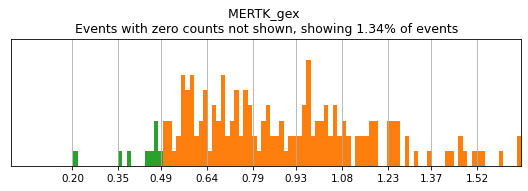

(0.5, 0)


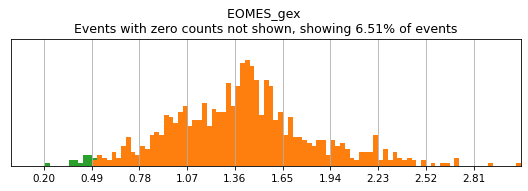

(0.5, 0)


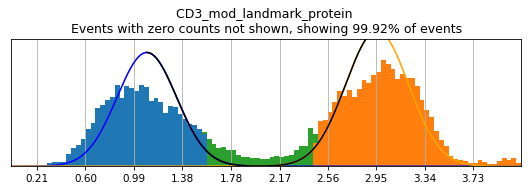

(2.4502483367178827, 1.57745156060985)


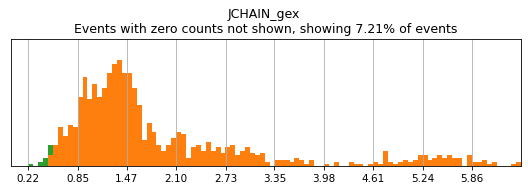

(0.5, 0)


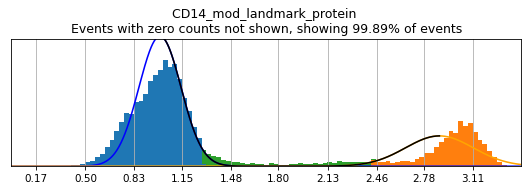

(2.4269029606185546, 1.2857260275571298)


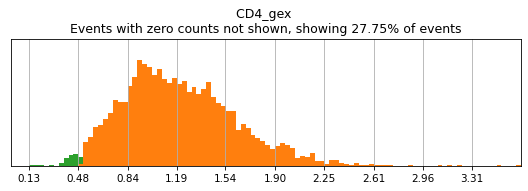

T_B doublets not found in adata, skipping thresholding.


(0.5, 0)


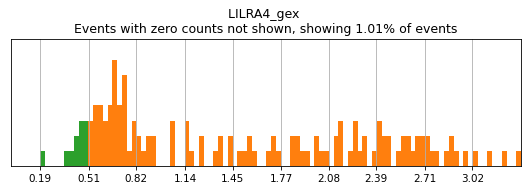

(0.5, 0)


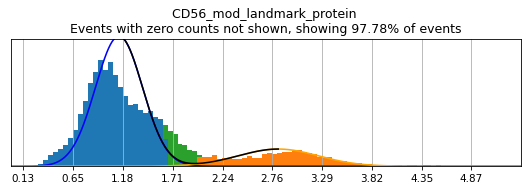

(1.98233294480174, 1.6403084482391141)


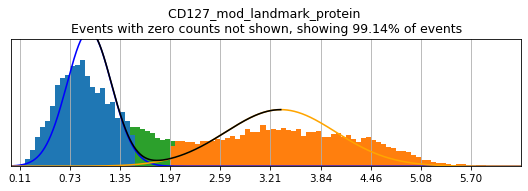

(1.9805827956989108, 1.519792999398581)


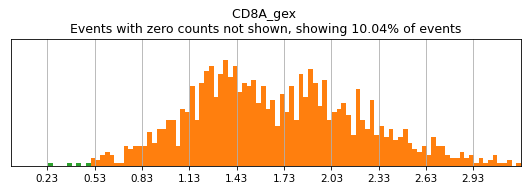

(0.5, 0)


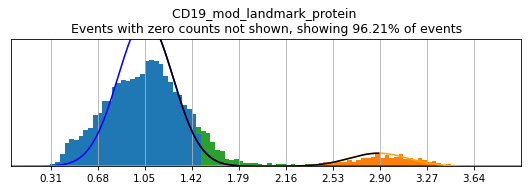

(2.426965454732814, 1.487831179028606)


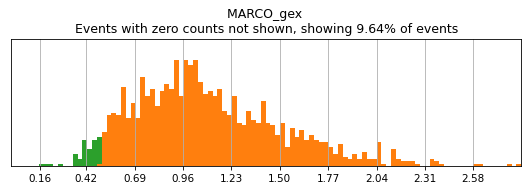

(0.5, 0)


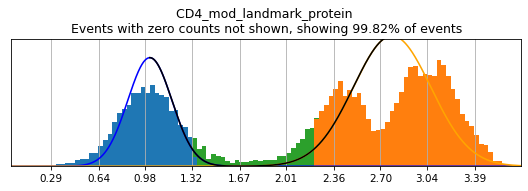

(2.2189858468054102, 1.3370991525443718)
Completed!


In [5]:
h.reset_thresholds()
h.run_all_thresholds(adata, mode='rerun all', interactive=False)

The `h.run_all_thresholds()` method is a useful helper function for plotting the hierarchy thresholds. There are 4 modes that can be activated for selecting which thresholds to draw:
1. `'fill in'`: Show thresholding for all markers that have not yet been thresholded.
2. `'rerun all'`: Show thresholding for all markers used in the hierarchy.
3. `'rerun specified`: Show thresholding for all markers specified in the object. This is often performs the same as `'rerun all'`.
4. `'every level'`: Show thresholding for all markers used in the hierarchy, separated by each level (allowing specification of different thresholds for the same marker on different levels).

Thresholds can be manually edited by using widgets (by adding `'fancy'` to the name of the mode), using the python `input` function (by passing the argument `interactive=True`), or by editing the .csv file that is loaded by `h.load_thresholds()`. Use `h.save_thresholds()` to generate an example of how this file should be formatted.

Each of these methods also has the option to specify a `batch_key` to threshold each batch separately, or you can specify a `batch_key=None`. By default, thresholding will be grouped by marker, not by batches. The `batch_marker_order` parameter can be used to reverse this.

Individual thresholds can also be set using the `h.set_threshold()` method. Here, there is no option for interactive editing. Instead, you can set whether this marker will be rerun interactively while running `mmc.classify()`. Typically, this is not very convenient, but it can be used to quickly alter individual thresholds.

In [6]:
h.set_threshold('CD19', (1.75,2.4), False)

#### Thresholding bimodal markers
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;On cleanly bimodal markers, thresholds are often best drawn to capture unambiguously positive and negative events, while leaving intermediate events undefined. This is a balance, however, as leaving too many intermediate cells undefined may limit training events to only the most extreme positive and negative events. This could inadvertently bias the random forest to classify a subset of the cell lineage or only high-quality data, neither of which would produce effective calls. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Thresholding is typically performed by either using `'fancy rerun all'` or `'fancy fill in'` to perform thresholds on all markers, or only those that have not been previously thresholded. Using `'fancy'`, two sliders will be displayed below a graph of the distribution of expression, defaulted to the locations where MMoCHi automatically set positive and negative thresholds. These sliders can be moved to change the location of these thresholds, with the greater of the two values always defining the positive threshold and the lesser value defining the negative threshold. Once manual thresholding is completed, you can click 'Click to run thresholds' in order to save these new thresholds. For an example of how the widgets should appear, see: [here](_static/ThresholdingWidgetsExample.png)!

Here, we use `limit` argument to only plot a few specified markers. Try adjusting thresholds on some bimodal markers here:

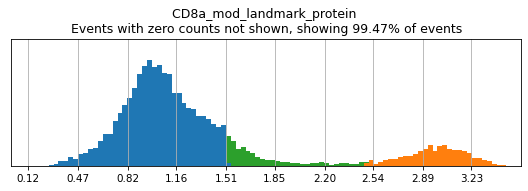

FloatSlider(value=2.4842246732501505, layout=Layout(width='600px'), max=3.579369265346928)

FloatSlider(value=1.5088917905284243, layout=Layout(width='600px'), max=3.579369265346928)

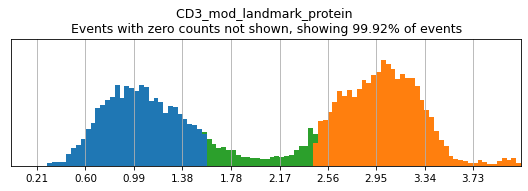

FloatSlider(value=2.4502483367178827, layout=Layout(width='600px'), max=4.120174659562347)

FloatSlider(value=1.57745156060985, layout=Layout(width='600px'), max=4.120174659562347)

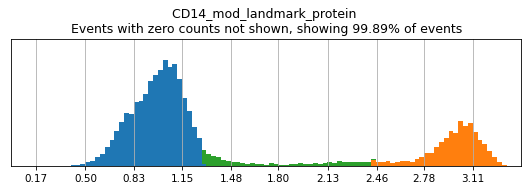

FloatSlider(value=2.4269029606185546, layout=Layout(width='600px'), max=3.433803744204542)

FloatSlider(value=1.2857260275571298, layout=Layout(width='600px'), max=3.433803744204542)

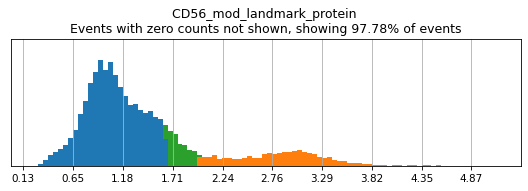

FloatSlider(value=1.98233294480174, layout=Layout(width='600px'), max=5.40150881778761)

FloatSlider(value=1.6403084482391141, layout=Layout(width='600px'), max=5.40150881778761)

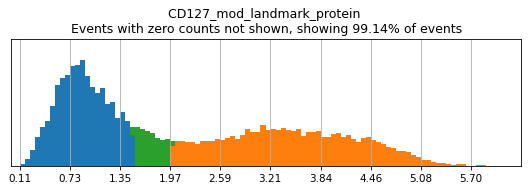

FloatSlider(value=1.9805827956989108, layout=Layout(width='600px'), max=6.320133566083647)

FloatSlider(value=1.519792999398581, layout=Layout(width='600px'), max=6.320133566083647)

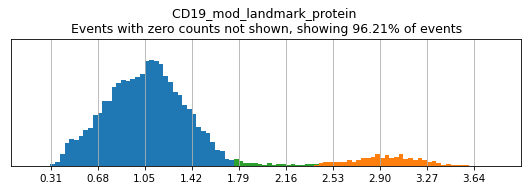

FloatSlider(value=2.4, layout=Layout(width='600px'), max=4.009825242409079)

FloatSlider(value=1.75, layout=Layout(width='600px'), max=4.009825242409079)

Completed!


Button(description='Click to run thresholds!', style=ButtonStyle())

Output()

In [7]:
h.run_all_thresholds(adata, mode='fancy rerun all', limit=['CD8a','CD19','CD3','CD127','CD56','CD14'])

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Similar to flow cytometry, bimodal populations may be hard to visualize on the total dataset and may require subsetting in advance to view. This can be achieved by masking the adata object to the parent subset before performing thresholding. Here, we can see that CD4 expression across the dataset is trimodal, with a middle peak representing monocytes with intermediate CD4 expression. 

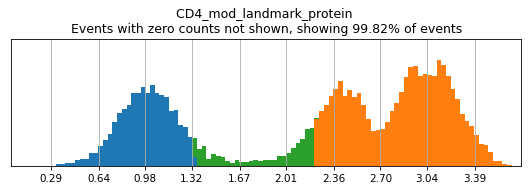

FloatSlider(value=2.2189858468054102, layout=Layout(width='600px'), max=3.7295516974970893)

FloatSlider(value=1.3370991525443718, layout=Layout(width='600px'), max=3.7295516974970893)

Completed!


Button(description='Click to run thresholds!', style=ButtonStyle())

Output()

In [8]:
h.run_all_thresholds(adata, mode='fancy rerun all', limit=['CD4'])


Subsetting to a few clusters of lymphocytes reveals a much clearer bimodal distribution. See the [Hierarchy Design tutorial](./Hierarchy_Design.ipynb) for an example of how to set up this masking properly when thresholding each level of the hierarchy. 

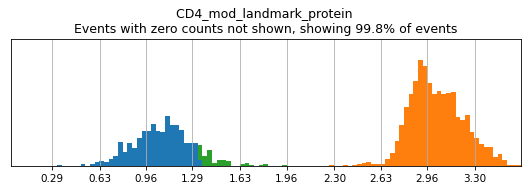

FloatSlider(value=2.2189858468054102, layout=Layout(width='600px'), max=3.6292916971590055)

FloatSlider(value=1.3370991525443718, layout=Layout(width='600px'), max=3.6292916971590055)

Completed!


Button(description='Click to run thresholds!', style=ButtonStyle())

Output()

In [9]:
mask = adata.obs.leiden.isin(['13','5','6','3'])
h.run_all_thresholds(adata[mask], mode='fancy rerun all', limit=['CD4'])

<div class="alert alert-info">
    
**Tip — Integrating thresholds across batches**

Thresholds should be drawn either using batch-corrected expression data, or on each batch separately to achieve the best results. Use the `batch_key` argument to define batches.
</div>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;It is also worth noting that some markers, despite a broadly bimodal appearance in their distribution, may be better thresholded with other targets in mind, such as very high expression, or to capture intermediate populations. We have developed helper functions to visualize thresholds directly on the UMAP, which we have found invaluable for defining optimal thresholds. Similar to the histograms, events are colored by their thresholded group: blue for negative, green for intermediate, and orange for positive. This is important to observe both on a sorted UMAP (to see everywhere this marker is expressed) and an unsorted UMAP (to see averages expression in specific areas of the UMAP or to assess coverage).

Running with batch batch
... storing 'leiden' as categorical


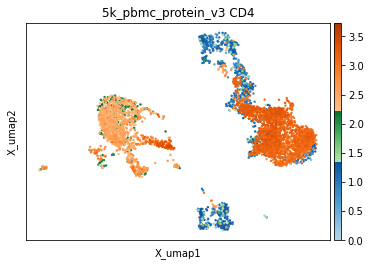

... storing 'leiden' as categorical


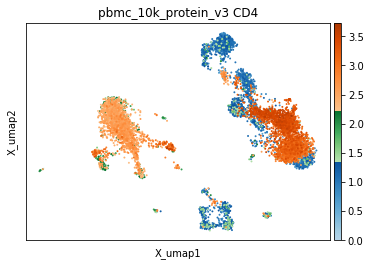

Running with batch batch
... storing 'leiden' as categorical


-----Unsorted-----


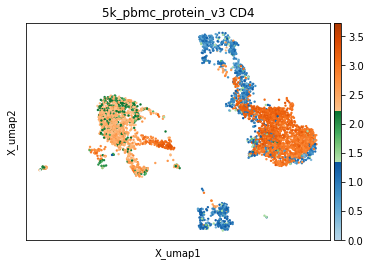

... storing 'leiden' as categorical


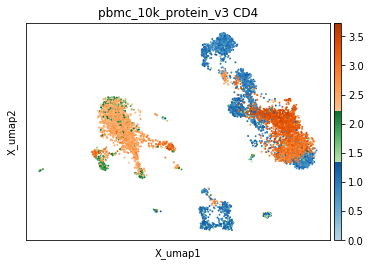

In [10]:
mmc.utils.umap_thresh(adata, h, ['CD4'])
print('-----Unsorted-----')
mmc.utils.umap_thresh(adata, h, ['CD4'], sort_order=False)

<div class="alert alert-info">
    
**Tip — Checking the results of high-confidence thresholding**

Sometimes, when altering thresholds, it can help to directly check the resulting high-confidence events without taking the time to train a random forest. For that, you can run the internal thresholding function directly, using `mmc.hc_threshold`. See docs for more details.
</div>

## Thresholding non-intuitive protein markers
There are many markers where drawing a threshold is not as intuitive as cleanly bimodal populations. For some markers, expression varies on a gradient, while for others, expression is trimodal or more. For these surface proteins, it generally makes sense to follow conventions of flow cytometry gating. 
For markers in batches with only one visible peak, you may need careful inspection of the sample characteristics or other coexpressed markers to determine whether that peak represents positive or negative expression. 

## Thresholding genes
For gene markers, a threshold capturing almost all cells with any expression is often sufficient for a tight positive gate. This is especially true for transcripts with high rates of dropout. For this, we typically set a threshold for anything above 0.5 log(counts per 10k+1). Look at some of the gates set here:

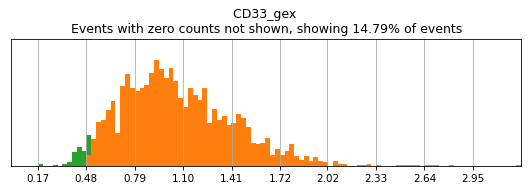

FloatSlider(value=0.5, layout=Layout(width='600px'), max=3.257295608520508)

FloatSlider(value=0.0, layout=Layout(width='600px'), max=3.257295608520508)

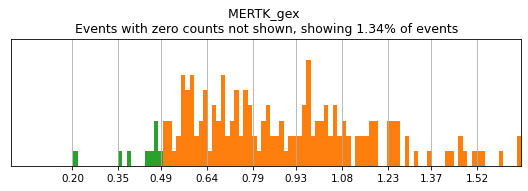

FloatSlider(value=0.5, layout=Layout(width='600px'), max=1.663966178894043)

FloatSlider(value=0.0, layout=Layout(width='600px'), max=1.663966178894043)

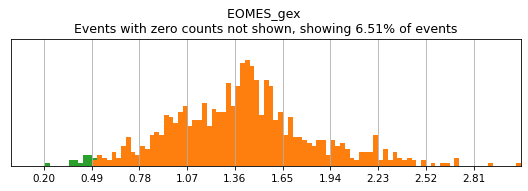

FloatSlider(value=0.5, layout=Layout(width='600px'), max=3.0994813442230225)

FloatSlider(value=0.0, layout=Layout(width='600px'), max=3.0994813442230225)

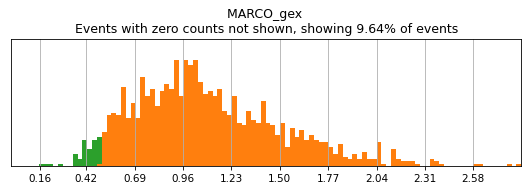

FloatSlider(value=0.5, layout=Layout(width='600px'), max=2.8468706607818604)

FloatSlider(value=0.0, layout=Layout(width='600px'), max=2.8468706607818604)

Completed!


Button(description='Click to run thresholds!', style=ButtonStyle())

Output()

In [11]:
h.run_all_thresholds(adata, data_key='protein', batch_key=None, mode='fancy rerun all', limit=['MARCO','MERTK','CD33','EOMES'])

On other markers, this sort of threshold is not sufficient. With gene expression, however, it can be quite tricky to find the proper threshold location. Again, this is where helper functions such as `mmc.utils.umap_thresh` come in handy. Here, you can see a lot of non-specific expression of the plasma cell marker *JCHAIN* and pDC marker *LILRA4*.

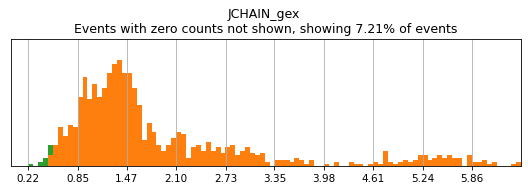

FloatSlider(value=0.5, layout=Layout(width='600px'), max=6.490779399871826)

FloatSlider(value=0.0, layout=Layout(width='600px'), max=6.490779399871826)

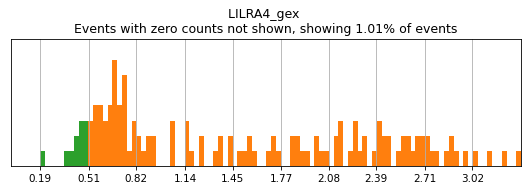

FloatSlider(value=0.5, layout=Layout(width='600px'), max=3.3392159938812256)

FloatSlider(value=0.0, layout=Layout(width='600px'), max=3.3392159938812256)

Completed!


Button(description='Click to run thresholds!', style=ButtonStyle())

Output()

In [12]:
h.run_all_thresholds(adata, data_key='protein', batch_key=None, mode='fancy rerun all', limit=['JCHAIN','LILRA4'])

... storing 'leiden' as categorical


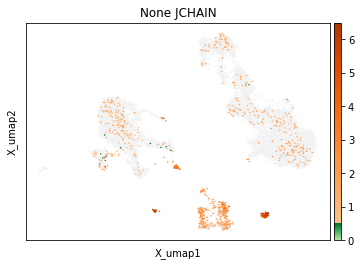

... storing 'leiden' as categorical


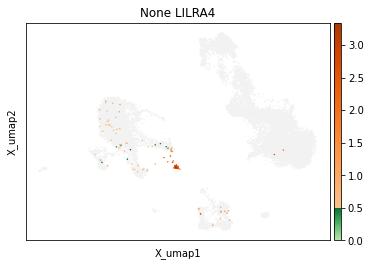

-----Unsorted-----


... storing 'leiden' as categorical


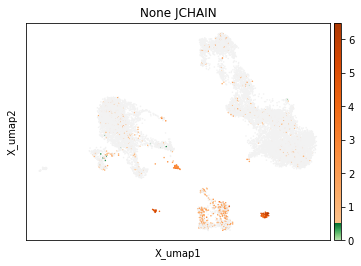

... storing 'leiden' as categorical


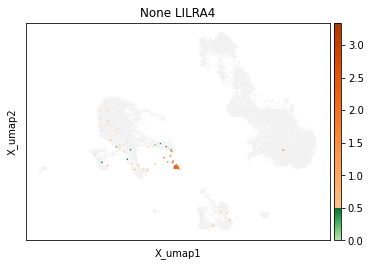

In [13]:
mmc.utils.umap_thresh(adata, h, ['JCHAIN', 'LILRA4'], batch_key=None)
print('-----Unsorted-----')
mmc.utils.umap_thresh(adata, h, ['JCHAIN', 'LILRA4'], batch_key=None, sort_order=False)

Adjusting these thresholds can greatly reduce the number of those mistakenly thresholded events.

... storing 'leiden' as categorical


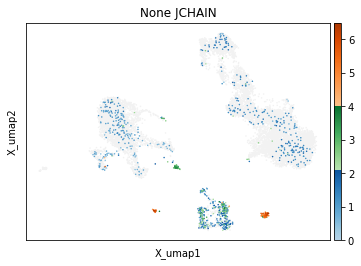

... storing 'leiden' as categorical


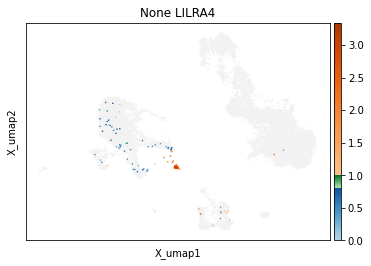

-----Unsorted-----


... storing 'leiden' as categorical


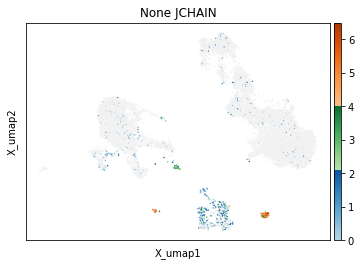

... storing 'leiden' as categorical


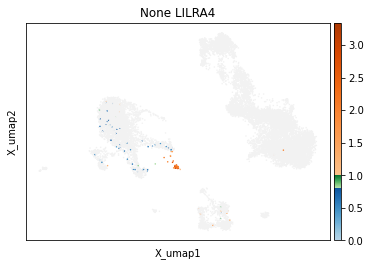

In [14]:
h.set_threshold('LILRA4', (.8,1), False)
h.set_threshold('JCHAIN', (2.1,4), False)
mmc.utils.umap_thresh(adata, h, ['JCHAIN', 'LILRA4'], batch_key=None)
print('-----Unsorted-----')
mmc.utils.umap_thresh(adata, h, ['JCHAIN', 'LILRA4'], batch_key=None, sort_order=False)

## **Saving and loading thresholds**

Be sure to save your thresholds to a .csv. These will be useful as you iteratively train the classifier to fine tune population identification. When overwriting a file, this special save function saves non-destructively, replacing only the markers that you define each run — so if you remove a marker temporarily from the hierarchy, those carefully defined thresholds will not be lost!

In [15]:
h.save_thresholds('data/thresholds.csv')

Saving non-destructively...


In [16]:
h.load_thresholds('data/thresholds.csv')

Loaded thresholds.


<div class="alert alert-success">
    
**Congratulations!** 
    
You can now cleanly select high-confidence cells through thresholding!<br>
</div>